In [1]:
## Most general notebook 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import gzip

# Form our test and train data
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import models 
from tensorflow.keras import layers 
from tensorflow.keras import initializers
from tensorflow.keras.models import load_model
#
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
# 
from collections import defaultdict
import keras.backend as K # for the loss function



Using TensorFlow backend.


In [98]:
def custom_loss(sigma =.1): ### Minimum Error Entropy
#     sigma = sigma
    def loss_fun(y_actual, y_predicted):
        y_actual = tf.convert_to_tensor(y_actual, dtype='float32' )
        y_predicted = tf.convert_to_tensor(y_predicted ,dtype='float32' )
        error_vec = tf.cast(y_actual,'float32')-tf.cast(y_predicted,'float32')    
        Error_V, Error_H = tf.meshgrid(error_vec, error_vec)
        arg_matrix = tf.cast(Error_V,'float32')-tf.cast(Error_H,'float32')
        pi= tf.cast(np.pi,'float32')
#         arg = tf.cast(2*3.14*sigma, dtype = 'float')
        MEE = - K.log(K.mean(K.exp(- .5*((arg_matrix /sigma) **2 ))))
        return MEE
    return loss_fun
    

In [120]:
x = tf.cast(4, dtype = 'float32')
K.sqrt(x)

<tf.Tensor 'Sqrt:0' shape=() dtype=float32>

In [2]:
def custom_loss_mod(sigma =.1): ### Minimum Error Entropy
#     sigma = sigma
    def loss_fun(y_actual, y_predicted):
#         y_actual = tf.convert_to_tensor(y_actual, dtype='float32' )
#         y_predicted = tf.convert_to_tensor(y_predicted ,dtype='float32' )
        error_vec = tf.cast(y_actual,'float32')-tf.cast(y_predicted,'float32')    
        Error_V, Error_H = tf.meshgrid(error_vec, error_vec)
        arg_matrix = tf.cast(Error_V,'float32')-tf.cast(Error_H,'float32')
#         pi= tf.cast(np.pi,'float32')
        arg = tf.cast(2*3.14*sigma, dtype = 'float')
        MEE = - K.log(K.mean((1/(K.sqrt(arg))*K.exp(- .5*((arg_matrix /sigma) **2 )))))
        return MEE
    return loss_fun

In [3]:
def Create_TDNN(DelaySize, nh, activation1, activation2, nhidden =1):
    network = models.Sequential()
    network.add(layers.Dense(nh, activation = activation1, input_shape = (DelaySize,)))
    network.add(layers.Dense(1,activation = activation2))
    return network

In [4]:
def create_path(loss , act1, act2, lr, sigma = 0):
    if loss =='MEE':
        path = 'C:\everything\Courses\EEL6814 - Neural Networks and Deep Learning\HW\HW5\SavedModels\MEE_'+ act1 + '_' + act2 + '_LR_'+ str(lr)+ '_Sigma_'+ str(sigma) + '.h5'
    else: 
        path = 'C:\everything\Courses\EEL6814 - Neural Networks and Deep Learning/HW/HW5\SavedModels\MSE_' + act1 + '_' + act2 + '_LR_'+ str(lr)+ '.h5'
    return path

In [5]:
def Compile_Train(network, loss, SavePath, lr = 0.001, check_weights = False, early_stopping = True, verbose = 1, batchnum = 10, epochs = 500):
    opt = keras.optimizers.Adam(learning_rate=lr)
    network.compile(optimizer=opt, loss=loss, metrics=['mean_absolute_error'])
    if early_stopping == True:
        callbacks = [EarlyStopping(monitor='val_loss', patience=20),
                 ModelCheckpoint(filepath=SavePath, monitor='val_loss', save_best_only=True)]
        # fitting here we include validation 
        history = network.fit(X_Train_Real,Y_Train_Real,
                          epochs=epochs,
                          batch_size=batchnum,
                          callbacks=callbacks, # Early stopping
                          validation_data=(X_Val,Y_Val),
                             verbose = verbose)
        # fitting, here no validation 
    else: 
        history = network.fit(X_Train,Y_Train,
                          epochs=epochs,
                          batch_size=batchnum,
                             verbose = verbose)
    return history 

# Data loading and preprocessing 

In [6]:
## load the testing data 
from scipy.io import loadmat
mat_dict = loadmat('train_tau_30.mat')
data = mat_dict['X1']
##### Data preprocessing
# reshape the data
data = data.reshape(data.shape[0],)
## create the data: 
n = data.shape[0]
delay_size  = 10
Data_Base = np.zeros((n - delay_size, delay_size+1))
i = 0
j = 0
k=0
while k < n:
    Data_Base[j, :-1] = data[i:i+ delay_size]
    Data_Base[j,-1] = data[i+delay_size]
    i = i+1
    j = j+1 
    k = i+ delay_size
# Scale the data
scl = MinMaxScaler()
scl.fit(Data_Base)
data_scl = scl.transform(Data_Base)

X_Train = data_scl[:,:-1]
Y_Train = data_scl[:,-1]
### test train split 
X_Train_Real,X_Val,Y_Train_Real,Y_Val = train_test_split(X_Train,Y_Train, test_size=0.1, random_state=42, shuffle = True)
# TEST SET 
mat_dict_test = loadmat('test_tau_30.mat')
# for key in mat_dict_test:
#     print(key)
data_test = mat_dict_test['Y1']
data_test = data_test.reshape(data_test.shape[0],)
## create the data: 
n = data_test.shape[0]
delay_size  = 10
Data_Base_Test = np.zeros((n - delay_size, delay_size+1))
i = 0
j = 0
k=0
while k < n:
    Data_Base_Test[j, :-1] = data_test[i:i+ delay_size]
    Data_Base_Test[j,-1] = data_test[i+delay_size]
    i = i+1
    j = j+1 
    k = i+ delay_size
# Scale the data
data_scl_test = scl.transform(Data_Base_Test)
X_Test = data_scl_test[:,:-1]
Y_Test = data_scl_test[:,-1]


# Using MEE criterion 

In [55]:
# X_Train_Real,X_Val,Y_Train_Real,Y_Val, X_Test,Y_Test
## testing the functions 
net = Create_TDNN(10,100,  'relu', 'relu' )
net.summary() ## okay that trains. 
sigma = .1
path = 'MEE_ ' + str(sigma) + '.h5'
history = Compile_Train(network = net, loss =  custom_loss(sigma),SavePath = path,  lr = .01)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 100)               1100      
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 101       
Total params: 1,201
Trainable params: 1,201
Non-trainable params: 0
_________________________________________________________________
Train on 891 samples, validate on 99 samples
Epoch 1/500
891/891 [==============================] - 1s 769us/sample - loss: 0.0669 - acc: 0.0022 - val_loss: 0.0076 - val_acc: 0.0000e+00
Epoch 2/500
891/891 [==============================] - 0s 122us/sample - loss: 9.7416e-04 - acc: 0.0022 - val_loss: 0.0034 - val_acc: 0.0000e+00
Epoch 3/500
891/891 [==============================] - 0s 100us/sample - loss: 0.0061 - acc: 0.0022 - val_loss: 0.0088 - val_acc: 0.0000e+00
Epoch 4/500
891/891 [====================

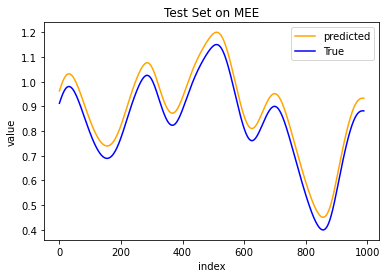

In [56]:
preds = net.predict(X_Test)
plt.plot(preds,color = 'orange', label = 'predicted')
plt.plot(Y_Test, color = 'blue', label = 'True')
plt.title('Test Set on MEE')
plt.xlabel('index')
plt.ylabel('value')

plt.legend()
plt.show()

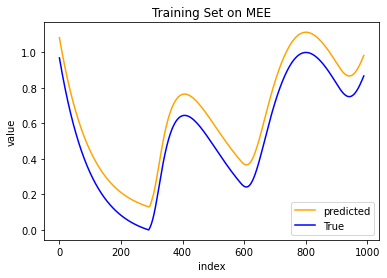

In [25]:
preds = net.predict(X_Train)
plt.plot(preds,color = 'orange', label = 'predicted')
plt.plot(Y_Train, color = 'blue', label = 'True')
plt.title('Training Set on MEE')
plt.xlabel('index')
plt.ylabel('value')

plt.legend()
plt.show()

In [65]:
X_Train_Real.shape

(891, 10)

In [69]:
Y_Train_Real.shape

(891,)

In [128]:
sigma_arr = [.1,.2,.3,.4,.5,.6,.7,.8,.9]
## for each learning rate - Train, store history , evaluate, store loss, predict and store predictions. 
TDNN_Sigma_Dict = defaultdict(lambda: "Not Present") 
Test_loss_sigma = np.zeros(len(sigma_arr))
Test_MAE_sigma = np.zeros(len(sigma_arr))
Pred_Mat_sigma = np.zeros((len(sigma_arr), X_Test.shape[0]))
epochs = 300 
batch_num = 1 
nh = 100
delay_size = 10
a1 = 'relu'
a2 = 'relu'
# sigma = .3
lr =.001
for i in range(len(sigma_arr)):
    sigma  = sigma_arr[i]
    print('sigma = ',sigma)
    ## Create the network 
    net = Create_TDNN(DelaySize = delay_size, nh = nh, activation1 = a1, activation2 = a2)
    # Create path 
    SavePath =  create_path(loss = 'MEE' , act1 = a1 , act2 = a2 , lr = lr, sigma = sigma)
    # Compile and train 
    his = Compile_Train(net,  custom_loss_mod(sigma), SavePath, lr = lr, epochs = epochs)
    TDNN_Sigma_Dict[sigma] = his.history
    print('finished_training')
#     trained_model = load_model(SavePath)
    preds = net.predict(X_Test)
    Test_loss_sigma[i], Test_MAE_sigma[i] = net.evaluate(X_Test,Y_Test) 
    Pred_Mat_sigma[i,:] = preds.reshape(X_Test.shape[0])
#     Val_loss_sigma[i] = np.min(his.history['val_loss'])
    print('finished')
    print()

sigma =  0.1
Train on 891 samples, validate on 99 samples
Epoch 1/300
891/891 [==============================] - 3s 3ms/sample - loss: -0.0979 - mean_absolute_error: 0.0642 - val_loss: -0.2121 - val_mean_absolute_error: 0.0214
Epoch 2/300
891/891 [==============================] - 0s 252us/sample - loss: -0.2146 - mean_absolute_error: 0.0200 - val_loss: -0.2239 - val_mean_absolute_error: 0.0164
Epoch 3/300
891/891 [==============================] - 0s 212us/sample - loss: -0.2257 - mean_absolute_error: 0.0169 - val_loss: -0.2295 - val_mean_absolute_error: 0.0150
Epoch 4/300
891/891 [==============================] - 0s 230us/sample - loss: -0.2305 - mean_absolute_error: 0.0171 - val_loss: -0.2316 - val_mean_absolute_error: 0.0154
Epoch 5/300
891/891 [==============================] - 0s 214us/sample - loss: -0.2321 - mean_absolute_error: 0.0191 - val_loss: -0.2324 - val_mean_absolute_error: 0.0176
Epoch 6/300
891/891 [==============================] - 0s 189us/sample - loss: -0.2324 - 

<function matplotlib.pyplot.show(close=None, block=None)>

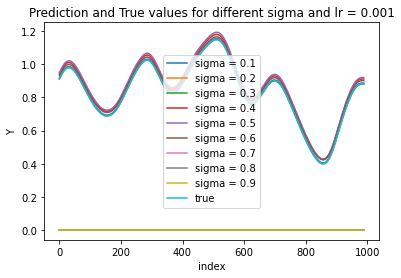

In [129]:
for i in range(len(sigma_arr)):
    plt.plot(Pred_Mat_sigma[i,:], label = 'sigma = ' + str(sigma_arr[i]))
plt.plot(Y_Test, label = 'true')
plt.legend()
plt.xlabel('index')
plt.ylabel('Y')
plt.title('Prediction and True values for different sigma and lr = 0.001')
# plt.ylim([0.9,1])
plt.show

In [130]:
minidx = np.argmin(Test_MAE_sigma)
print(sigma_arr[minidx])

0.8


<function matplotlib.pyplot.show(close=None, block=None)>

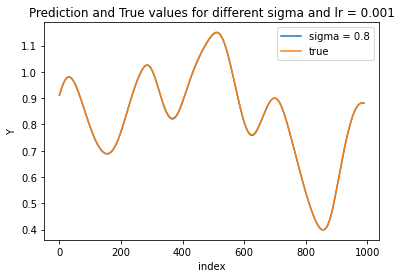

In [131]:
### this was using loss_fun not loss_fun_mod
for i in np.array([minidx]):
    plt.plot(Pred_Mat_sigma[i,:], label = 'sigma = ' + str(sigma_arr[i]))
plt.plot(Y_Test, label = 'true')
plt.legend()
plt.xlabel('index')
plt.ylabel('Y')
plt.title('Prediction and True values for different sigma and lr = 0.001')
# plt.ylim([0.9,1])
plt.show

In [90]:
min_idx = np.argmin(Val_loss_sigma)
sigma_arr[min_idx]

0.9

In [92]:
loss, mae = net.evaluate(X_Test,Y_Test)

990/990 [==============================] - 0s 37us/sample - loss: 1.2523e-07 - mean_absolute_error: 0.0138


In [77]:
# sigma of 0.6 wins 
sigma_arr = [.1,.2,.3,.4,.5,.6,.7,.8,.9]
## for each learning rate - Train, store history , evaluate, store loss, predict and store predictions. 
TDNN_Sigma_Dict_mod = defaultdict(lambda: "Not Present") 
Test_loss_sigma = np.zeros(len(sigma_arr))
Val_loss_sigma = np.zeros(len(sigma_arr))
Pred_Mat_sigma = np.zeros((len(sigma_arr), X_Test.shape[0]))
epochs = 300 
batch_num = 1 
nh = 100
delay_size = 10
a1 = 'relu'
a2 = 'relu'
sigma = .3
lr =.01
for i in range(len(sigma_arr)):
    sigma  = sigma_arr[i]
    print('sigma = ',sigma_arr)
    ## Create the network 
    net = Create_TDNN(DelaySize = delay_size, nh = nh, activation1 = a1, activation2 = a2)
    # Create path 
    SavePath =  create_path(loss = 'MEE' , act1 = a1 , act2 = a2 , lr = lr, sigma = sigma)
    # Compile and train 
    his = Compile_Train(net,  custom_loss_mod(sigma), SavePath, lr = lr, epochs = epochs)
    TDNN_Sigma_Dict_mod[sigma] = his.history
#     trained_net = load_model(SavePath)
#     the_loss, the_acc = trained_net.evaluate(X_Test, Y_Test)
    preds = net.predict(X_Test)
    Pred_Mat_sigma[i,:] = preds.reshape(X_Test.shape[0])
    Val_loss_sigma[i] = np.min(his.history['val_loss'])
    print('finished')
    print()

sigma =  [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
Train on 891 samples, validate on 99 samples
Epoch 1/300
891/891 [==============================] - 1s 1ms/sample - loss: -1.2992 - acc: 0.0022 - val_loss: -1.3583 - val_acc: 0.0000e+00
Epoch 2/300
891/891 [==============================] - 0s 145us/sample - loss: -1.3638 - acc: 0.0022 - val_loss: -1.3829 - val_acc: 0.0000e+00
Epoch 3/300
891/891 [==============================] - 0s 183us/sample - loss: -1.3834 - acc: 0.0022 - val_loss: -1.3835 - val_acc: 0.0000e+00
Epoch 4/300
891/891 [==============================] - 0s 154us/sample - loss: -1.3825 - acc: 0.0022 - val_loss: -1.3813 - val_acc: 0.0000e+00
Epoch 5/300
891/891 [==============================] - 0s 178us/sample - loss: -1.3834 - acc: 0.0022 - val_loss: -1.3835 - val_acc: 0.0000e+00
Epoch 6/300
891/891 [==============================] - 0s 119us/sample - loss: -1.3832 - acc: 0.0022 - val_loss: -1.3831 - val_acc: 0.0000e+00
Epoch 7/300
891/891 [=======================

<function matplotlib.pyplot.show(close=None, block=None)>

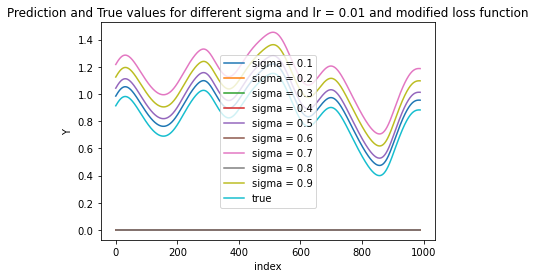

In [78]:
for i in range(len(sigma_arr)):
    plt.plot(Pred_Mat_sigma[i,:], label = 'sigma = ' + str(sigma_arr[i]))
plt.plot(Y_Test, label = 'true')
plt.legend()
plt.xlabel('index')
plt.ylabel('Y')
plt.title('Prediction and True values for different sigma and lr = 0.01 and modified loss function')
plt.show

## Adding noise to the data


In [108]:
noise = .95* np.random.normal(0, .5, data.shape[0]) + 0.05*  np.random.normal(1, .5,  data.shape[0])
data_noisy = data+ noise
n = data_noisy.shape[0]
delay_size  = 10
Data_Base_noisy = np.zeros((n - delay_size, delay_size+1))
i = 0
j = 0
k=0
while k < n:
    Data_Base_noisy[j, :-1] = data_noisy[i:i+ delay_size]
    Data_Base_noisy[j,-1] = data_noisy[i+delay_size]
    i = i+1
    j = j+1 
    k = i+ delay_size
# Scale the data
scl = MinMaxScaler()
scl.fit(Data_Base_noisy)
data_scl_noisy = scl.transform(Data_Base_noisy)

X_Train_noisy = data_scl_noisy[:,:-1]
Y_Train_noisy = data_scl_noisy[:,-1]
### test train split 
X_Train_Real_noisy,X_Val_noisy,Y_Train_Real_noisy,Y_Val_noisy = train_test_split(X_Train_noisy,Y_Train_noisy, test_size=0.1, random_state=42, shuffle = True)

In [110]:
# Compile_Train(network, loss, SavePath, lr = 0.001, check_weights = False, early_stopping = True, verbose = 1, batchnum = 10, epochs = 500):
network = Create_TDNN(DelaySize = delay_size, nh = nh, activation1 = a1, activation2 = a2)
opt = keras.optimizers.Adam(learning_rate=0.001)
SavePath = 'NoisyMEE1202.h5'
network.compile(optimizer=opt, loss=custom_loss(sigma =.2), metrics=['mean_absolute_error'])
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
         ModelCheckpoint(filepath=SavePath, monitor='val_loss', save_best_only=True)]
# fitting here we include validation 
history = network.fit(X_Train_Real_noisy,Y_Train_Real_noisy,
                  epochs=100,
                  batch_size=200,
                  callbacks=callbacks, # Early stopping
                  validation_data=(X_Val_noisy,Y_Val_noisy),
                     verbose = 1)
    # fitting, here no validation 


Train on 891 samples, validate on 99 samples
Epoch 1/100
891/891 [==============================] - 3s 3ms/sample - loss: 0.3890 - mean_absolute_error: 0.1273 - val_loss: 0.3954 - val_mean_absolute_error: 0.1306
Epoch 2/100
891/891 [==============================] - 0s 59us/sample - loss: 0.3709 - mean_absolute_error: 0.1312 - val_loss: 0.3874 - val_mean_absolute_error: 0.1322
Epoch 3/100
891/891 [==============================] - 0s 48us/sample - loss: 0.3615 - mean_absolute_error: 0.1297 - val_loss: 0.3856 - val_mean_absolute_error: 0.1325
Epoch 4/100
891/891 [==============================] - 0s 56us/sample - loss: 0.3560 - mean_absolute_error: 0.1288 - val_loss: 0.3848 - val_mean_absolute_error: 0.1335
Epoch 5/100
891/891 [==============================] - 0s 26us/sample - loss: 0.3503 - mean_absolute_error: 0.1273 - val_loss: 0.3855 - val_mean_absolute_error: 0.1321
Epoch 6/100
891/891 [==============================] - 0s 29us/sample - loss: 0.3505 - mean_absolute_error: 0.1237 -

In [111]:
y_pred = network.predict(X_Test)

<function matplotlib.pyplot.show(close=None, block=None)>

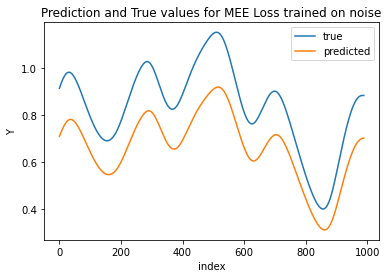

In [112]:
# for i in np.array([1]):
#     plt.plot(Pred_Mat_sigma[i,:], label = 'sigma = ' + str(sigma_arr[i]))
plt.plot(Y_Test, label = 'true')
plt.plot(y_pred, label = 'predicted')
plt.legend()
plt.xlabel('index')
plt.ylabel('Y')
plt.title('Prediction and True values for MEE Loss trained on noise')
# plt.ylim([0.9,1])
plt.show

In [116]:
# TEST SET 
mat_dict_test = loadmat('test_tau_30.mat')
# for key in mat_dict_test:
#     print(key)
data_test = mat_dict_test['Y1']
data_test = data_test.reshape(data_test.shape[0],)
## create the data: 
n = data_test.shape[0]
delay_size  = 10
Data_Base_Test = np.zeros((n - delay_size, delay_size+1))
i = 0
j = 0
k=0
while k < n:
    Data_Base_Test[j, :-1] = data_test[i:i+ delay_size]
    Data_Base_Test[j,-1] = data_test[i+delay_size]
    i = i+1
    j = j+1 
    k = i+ delay_size
# Scale the data
data_scl_test = scl.transform(Data_Base_Test)
X_Test_Noisy = data_scl_test[:,:-1]
Y_Test_noisy = data_scl_test[:,-1]


<function matplotlib.pyplot.show(close=None, block=None)>

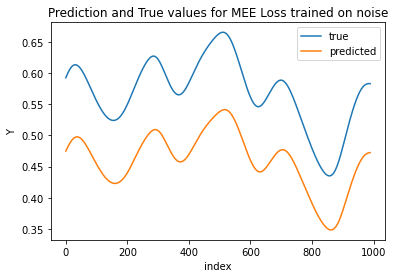

In [117]:
y_pred = network.predict(X_Test_Noisy)
# for i in np.array([1]):
#     plt.plot(Pred_Mat_sigma[i,:], label = 'sigma = ' + str(sigma_arr[i]))
plt.plot(Y_Test_noisy, label = 'true')
plt.plot(y_pred, label = 'predicted')
plt.legend()
plt.xlabel('index')
plt.ylabel('Y')
plt.title('Prediction and True values for MEE Loss trained on noise')
# plt.ylim([0.9,1])
plt.show